In [1]:
### Importing common items
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')

In [2]:
dmdt_by_Name_Band_50x50 = '/home/shoaib/Thesis/dmdt_Analysis/Histograms/dmdt_by_Name_Band_50x50.pkl'

Let's understand our distribution a little better.

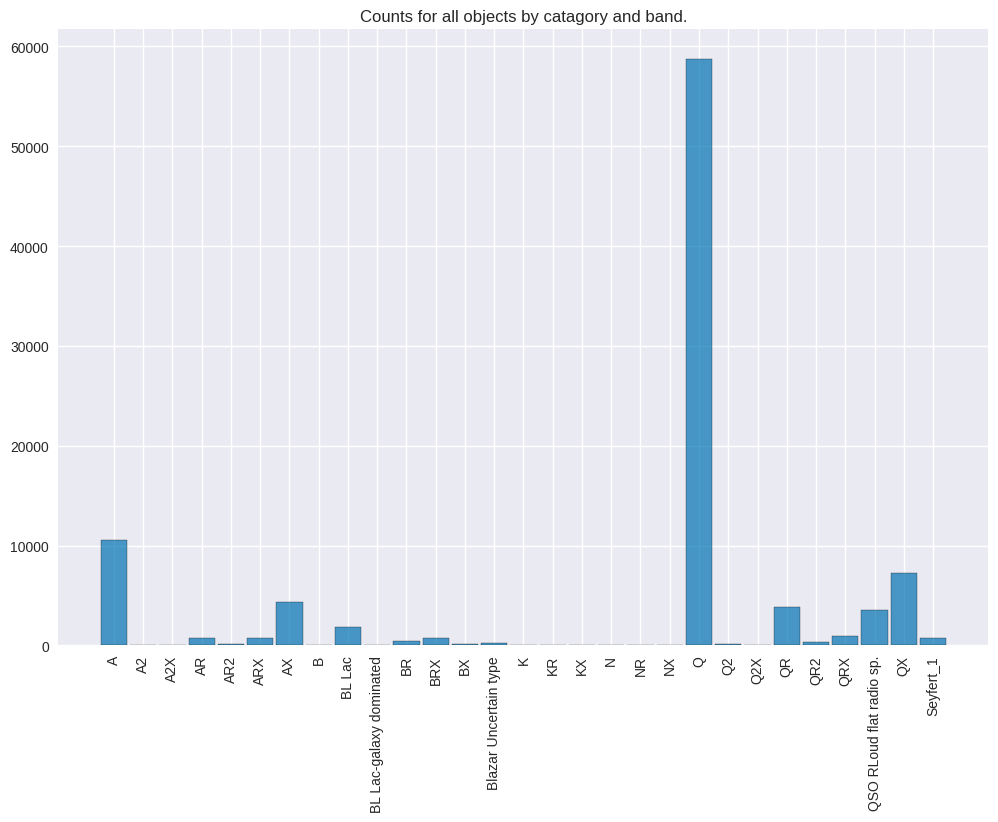

In [3]:
### plotting the distribution
dmdt_by_Name_Band_50x50_df = pd.read_pickle(dmdt_by_Name_Band_50x50)
type_array = dmdt_by_Name_Band_50x50_df['type'].to_numpy()

plt.figure(figsize=(12,8))

counts, bin_edges, _ = plt.hist(type_array, bins=len(set(type_array)), edgecolor='black', alpha=0.7, align='mid', rwidth=0.9)

categories = sorted(set(type_array))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.xticks(bin_centers, labels=categories, rotation=90)
plt.title('Counts for all objects by catagory and band.')

plt.show()

del type_array, counts, bin_edges, dmdt_by_Name_Band_50x50_df

We'll only consider the Q, QR, and QX catagories, while watching out for that large diaparity!

### RPCA with FBPCA

In [4]:
import fbpca
import scipy

In [5]:
TOL=1e-9
MAX_ITERS=3

def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

def norm_op(M): return _svd(M, 1)[1][0]

def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

def pcp(X, maxiter=10, k=10, example_column=140): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[example_column,:], L[example_column,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [6]:
# dmdt_by_Name_Band_50x50_df = pd.read_pickle(dmdt_by_Name_Band_50x50)
# # dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df.sample(frac=0.2)
# dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df.drop(columns=['n_good_det', 'histogram'])
# dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df[dmdt_by_Name_Band_50x50_df['type'].isin(['Q', 'QR', 'QX'])]

# hists_by_name_band = dmdt_by_Name_Band_50x50_df['histogram_normalised'].to_numpy()

# del dmdt_by_Name_Band_50x50_df

# M = np.stack([arr.flatten() for arr in hists_by_name_band], axis=1)
# # L, S, examples =  pcp(M, maxiter=7, k=10, example_column=5000)

In [7]:
# np.save('/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/M_QSOsOnly_allbands.npy', M)
# np.save('/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/L_QSOsOnly_allbands.npy', L)
# np.save('/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/S_QSOsOnly_allbands.npy', S)
# del M, L

# M = np.load('/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/M_QSOsOnly_allbands.npy')
# L = np.load('/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/L_QSOsOnly_allbands.npy')

In [8]:
S = np.load('/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/S_QSOsOnly_allbands.npy')

dmdt_by_Name_Band_50x50_df = pd.read_pickle(dmdt_by_Name_Band_50x50)
# dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df.sample(frac=0.2)
dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df.drop(columns=['n_good_det', 'histogram'])
dmdt_by_Name_Band_50x50_df = dmdt_by_Name_Band_50x50_df[dmdt_by_Name_Band_50x50_df['type'].isin(['Q', 'QR', 'QX'])]

In [12]:
for index, row in dmdt_by_Name_Band_50x50_df.iterrows():
    array = S[:, index].reshape(50, 50)
    array_normalized = (array - array.min()) / (array.max() - array.min()) * 255
    array_normalized = array_normalized.astype(np.uint8)
    image = Image.fromarray(array_normalized)

    name, obj_type, band = row['name'], row['type'], row['band']
    image.save(f'/home/shoaib/Thesis/dmdt_Analysis/Histograms/FBPCA/QSOsOnly_allbands_S_Images/{name}_{obj_type}_{band}.png')
    print(f'{index} of {len(dmdt_by_Name_Band_50x50_df)} images saved')

20173 of 69895 images saved
20174 of 69895 images saved
20175 of 69895 images saved
20176 of 69895 images saved
20177 of 69895 images saved
20178 of 69895 images saved
20179 of 69895 images saved
20180 of 69895 images saved
20181 of 69895 images saved
20182 of 69895 images saved
20183 of 69895 images saved
20184 of 69895 images saved
20185 of 69895 images saved
20186 of 69895 images saved
20187 of 69895 images saved
20188 of 69895 images saved
20189 of 69895 images saved
20190 of 69895 images saved
20191 of 69895 images saved
20192 of 69895 images saved
20193 of 69895 images saved
20194 of 69895 images saved
20195 of 69895 images saved
20196 of 69895 images saved
20197 of 69895 images saved
20198 of 69895 images saved
20199 of 69895 images saved
20200 of 69895 images saved
20201 of 69895 images saved
20202 of 69895 images saved
20203 of 69895 images saved
20204 of 69895 images saved
20205 of 69895 images saved
20206 of 69895 images saved
20207 of 69895 images saved
20208 of 69895 image

IndexError: index 69895 is out of bounds for axis 1 with size 69895

In [16]:
for column_index in range(S.shape[1]):
    array = S[:, column_index].reshape(50, 50)
    array_normalized = (array - array.min()) / (array.max() - array.min()) * 255
    array_normalized = array_normalized.astype(np.uint8)
    image = Image.fromarray(array_normalized)
    image.save('greyscale_image.png')


(2500, 69895)

In [18]:
dmdt_by_Name_Band_50x50_df = pd.read_pickle(dmdt_by_Name_Band_50x50)

In [19]:
len(dmdt_by_Name_Band_50x50_df)

95875

2500

In [10]:
for i in img  =S[:, 6].reshape(50, 50)

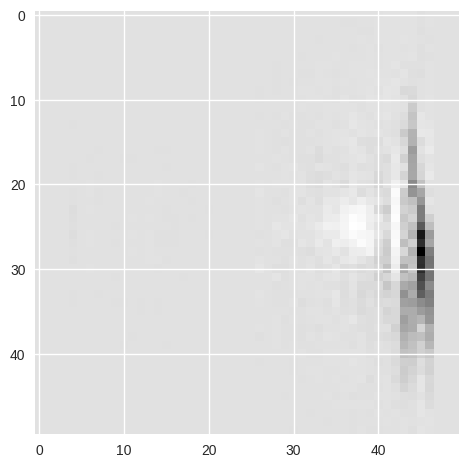

In [12]:
plt.imshow(array_normalized)

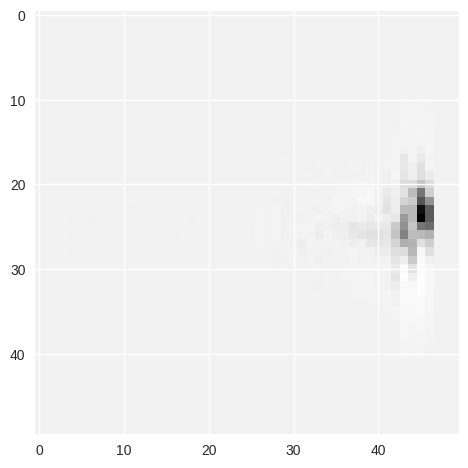

In [14]:
plt.imshow(S[:, 77].reshape(50, 50))

In [ ]:
# Normalize images
images = images / 255.0

# Add channel dimension for grayscale images
images = np.expand_dims(images, axis=1)  # Shape: (1000, 1, 50, 50)

# Convert to PyTorch tensors
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [33]:
from fastai.data.core import DataLoaders
from torch.utils.data import TensorDataset, DataLoader
import pytorch as torch

# Create datasets
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

# DataLoaders with FastAI
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
dls = DataLoaders(train_dl, val_dl)

/home/shoaib/.conda/envs/fastai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'torch' is not defined

In [15]:
### FastAI
from fastai.vision.all import *
import torch.nn as nn
from fastai.metrics import F1Score, accuracy, RocAuc, mae, mse

/home/shoaib/.conda/envs/fastai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Normalize images
images = images / 255.0

# Add channel dimension for grayscale images
images = np.expand_dims(images, axis=1)  # Shape: (1000, 1, 50, 50)

# Convert to PyTorch tensors
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from fastai.data.core import DataLoaders
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

# Wrap into FastAI DataLoaders
dls = DataLoaders(train_dl, val_dl)

In [ ]:
from fastai.vision.all import *

# Define a simple CNN using FastAI's API
def create_cnn():
    return nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 12 * 12, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 4),  # Output layer for 4 categories
    )

model = create_cnn()

In [ ]:
seed = 42  # For reproducibility
root_dir = '/home/shoaib/PSChallenge/Stacking/dm_dt_type_band_diffs_by_OID/'

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_x=ColReader('oid_alerce', pref=f'{root_dir}', suff='.png'),  # Adjust path as needed
    get_y=ColReader('type'),
    splitter=RandomSplitter(0.2, seed=seed),
    # item_tfms=[CropPad(96)],
    # batch_tfms=aug_transforms(
    #     max_zoom=1.0, flip_vert=True, max_lighting=0.0, max_warp=0.0
    # ) + [Normalize]
)

dls = ImageDataLoaders.from_dblock(dblock, all_lightcurves, path=root_dir, bs=32)

NameError: name 'images' is not defined

In [ ]:
# Convert single-channel grayscale images to 3-channel format
images_rgb = np.repeat(images, 3, axis=1)  # Shape: (1000, 3, 50, 50)

In [ ]:
from fastai.data.core import DataLoaders
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

# DataLoaders with FastAI
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
dls = DataLoaders(train_dl, val_dl)

In [ ]:
from fastai.vision.all import *

# Create the Learner with a pretrained ResNet
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
# Find an optimal learning rate
learn.lr_find()

# Train the model
learn.fit_one_cycle(10, 1e-3)  # 10 epochs, learning rate 0.001
